### Initial Stuff

In [1]:
import torch
import torchvision
import iecdt_lab
# import train_autoencoder
# from torch import nn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import Image
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import tqdm
import numpy as np
import os
import yaml
import json
%matplotlib inline

In [2]:
TILES_FILE = "/gws/nopw/j04/iecdt/deep_learning_lab/1km_naturalcolor_numpy"
TEST_METADATA = "/gws/nopw/j04/iecdt/deep_learning_lab/1km_naturalcolor_metadata_time_test.csv"
TILES_STATISTICS = "/gws/nopw/j04/iecdt/deep_learning_lab/1km_naturalcolor_metadata_rgb_stats.npz"

# The Autoencoder

In [3]:
"""Specify the path to the autoencoder you want here:"""
model_dir = "logs/test/runs/Default_1"

## Autoencoder Structure and Training Algorithm

Autoencoder is currently symmetric, with the decoder being structured inversely to the encoder:

The encoder has:

3 convolution layers (with relu activation functions) and 1 fully connected linear layer (no activation function afterwards).

Convolution all have:
* kernel size = 3
* stride = 3 
* padding = 1

First, second, and third convolutions output a batch size of 32, 64, and 128, respectively.

Fully connected linear layer compresses flattened output of previous layer into an array of size `latent_dim` (default is 128), which is then wacked into a sigmoid.


It is optimised using adam optimising a MSELoss (divided by batch size) between the input and output images.

The default training hyperparameters are:
* epoch num = 10
* batch size = 128
* learning rate = 0.001

## Autoencoder Performance

In [4]:
#Specify device
device=torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device)

#Read of model configuration.
path_to_config = model_dir+'/.hydra/config.yaml'

with open(path_to_config) as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

with open(path_to_config) as stream:
    try:
        print(json.dumps(yaml.safe_load(stream), indent=4))
    except yaml.YAMLError as exc:
        print(exc)

cuda
{
    "name": "test",
    "smoke_test": false,
    "seed": 0,
    "device": "cuda",
    "log_freq": 10,
    "epochs": 10,
    "learning_rate": 0.001,
    "batch_size": 128,
    "max_pooling": false,
    "sigmoid": false,
    "stride": 3,
    "latent_dim": 128,
    "dataloader_workers": 1,
    "load_tiles": true,
    "tiles_path": "/gws/nopw/j04/iecdt/deep_learning_lab/1km_naturalcolor_numpy",
    "train_metadata": "/gws/nopw/j04/iecdt/deep_learning_lab/1km_naturalcolor_metadata_time_train.csv",
    "val_metadata": "/gws/nopw/j04/iecdt/deep_learning_lab/1km_naturalcolor_metadata_time_val.csv",
    "train_rgb_stats": "/gws/nopw/j04/iecdt/deep_learning_lab/1km_naturalcolor_metadata_rgb_stats.npz",
    "wandb": {
        "mode": "offline",
        "project": "iecdt_deep_learning_lab"
    }
}


In [5]:
#Specify model info
latent_dim=config['latent_dim']
max_pooling=config['max_pooling']
sigmoid = config['sigmoid']
stride = config['stride']

path_to_model = model_dir+"/model.pth"

model = iecdt_lab.autoencoder.CNNAutoencoder(
    latent_dim=latent_dim,
    max_pooling=max_pooling,
    sigmoid=sigmoid,
    stride=stride
)

model.load_state_dict(torch.load(path_to_model,map_location=device,weights_only=True))
model = model.to(device)
model.eval()

CNNAutoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (linear): Linear(in_features=131072, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (linear): Linear(in_features=128, out_features=131072, bias=True)
    (conv1): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv4): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

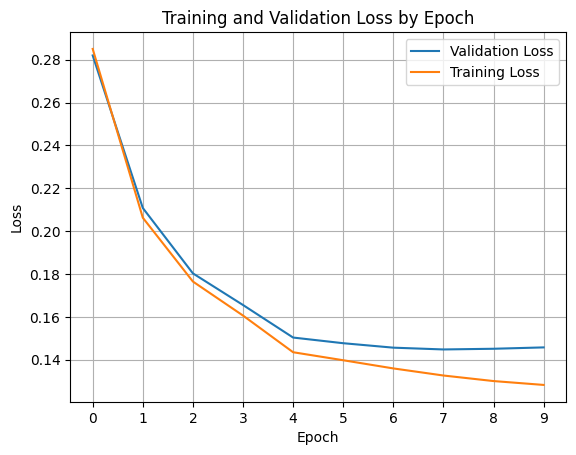

In [6]:
path_to_val_error = model_dir+'/val_error.csv'
path_to_train_error = model_dir+'/tra_error.csv'

val_error = np.genfromtxt(path_to_val_error, delimiter=',')
tra_error = np.genfromtxt(path_to_train_error, delimiter=',')

fig,ax = plt.subplots()

ax.plot(val_error,label='Validation Loss')
ax.plot(tra_error,label='Training Loss')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.grid()
ax.set_title('Training and Validation Loss by Epoch')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

### Display Example Reconstruction Images (UNCOMMENT TO DISPLAY)

In [7]:
# path_to_images = model_dir+'/wandb/latest-run/files/media/images'

# Epoch=1
# for image_path in os.listdir(path_to_images):
#     print(f'Epoch = {Epoch}')
#     display(Image(path_to_images+'/'+image_path))
#     Epoch+=1

# Compute Autoencoder Embeddings

In [8]:
data_stats = np.load(TILES_STATISTICS)
data_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=data_stats["rgb_mean"], std=data_stats["rgb_std"]
        ),
    ]
)
test_ds = iecdt_lab.data_loader.GOESRGBTiles(
    tiles_file=TILES_FILE,
    metadata_file=TEST_METADATA,
    transform=data_transforms,
)
test_data_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=64,
    shuffle=True,
    num_workers=16,
)

Remove the decoder of the autoencoder so the model outputs the embeddings before the final layer.

In [9]:
embedding_model = torch.nn.Sequential(*list(model.children())[:-1])
embedding_model.eval()

Sequential(
  (0): Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (linear): Linear(in_features=131072, out_features=128, bias=True)
  )
)

Compute the actual embeddings for all of the test dataset. This cell will take a couple of minutes to run!

In [10]:
embeddings = []
for batch, labels in tqdm.tqdm(test_data_loader):
    with torch.no_grad():
        batch = batch.to(device) #Make sure that the batch datatype matches the model datatype
        embeddings.append(embedding_model(batch).to('cpu').numpy()) #Need to be cpu type to save as numpy file
embeddings = np.concatenate(embeddings, axis=0)
embeddings = embeddings.reshape(embeddings.shape[0], -1)
print(embeddings.shape)

100%|██████████| 58/58 [00:07<00:00,  7.48it/s]

(3696, 128)


# Cluster the Embeddings

In [11]:
def plot_cluster_tiles(cluster_labels, tile_dataset, num_samples=5) -> plt.Figure:
    """Plot the clusters of the test tiles. Each column is a cluster."""
    num_clusters = len(np.unique(cluster_labels))
    fig, axs = plt.subplots(
        num_samples, num_clusters, figsize=(num_clusters * 2, num_samples * 2)
    )
    for i in range(num_clusters):
        cluster_ixs = np.where(cluster_labels == i)[0]
        for j in range(num_samples):
            if j < len(cluster_ixs):
                tile, _ = tile_dataset[cluster_ixs[j]]
                axs[j, i].imshow(tile)
            axs[j, i].axis("off")

        axs[0, i].set_title(f"Cluster {i}")

    fig.tight_layout()
    return fig

def plot_clusters(cluster_labels, pca_embeddings) -> plt.Figure:
    """Plot the clusters in the PCA space."""
    fig, ax = plt.subplots(figsize=(8, 8))
    for i in np.unique(cluster_labels):
        cluster_ixs = np.where(cluster_labels == i)[0]
        ax.scatter(
            pca_embeddings[cluster_ixs, 0],
            pca_embeddings[cluster_ixs, 1],
            label=f"Cluster {i}",
        )
    ax.legend()
    return fig

To get some understanding of how the embedding space is structured we will first reduce the embedding dimensionality using principal component analysis (PCA) and then cluster using KMeans. Feel free to experiment with different dimensionality reduction methods and clustering algorithms!

In [12]:
pca = PCA(n_components=0.92)
pca_embeddings = pca.fit_transform(embeddings)

kmeans = KMeans(n_clusters=5, random_state=0).fit(pca_embeddings)
cluster_labels = kmeans.predict(pca_embeddings)

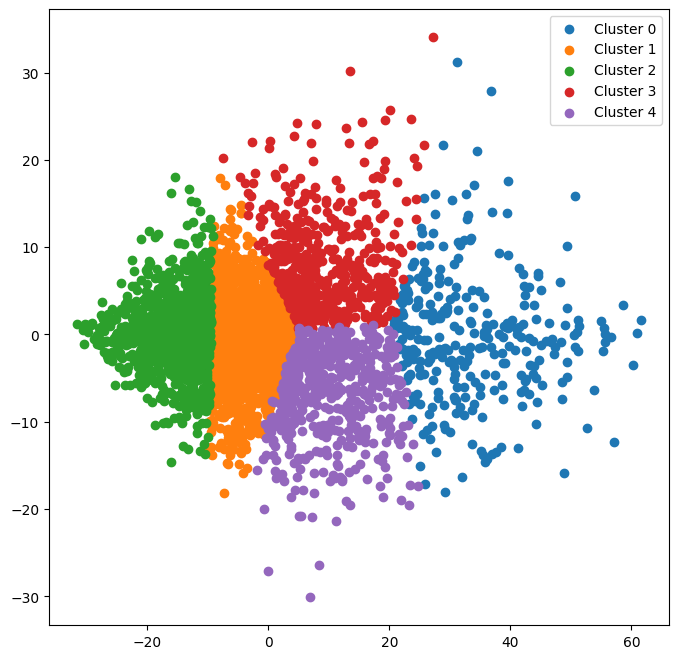

In [13]:
_ = plot_clusters(cluster_labels, pca_embeddings)

In [14]:
test_ds_no_transform = iecdt_lab.data_loader.GOESRGBTiles(
    tiles_file=TILES_FILE,
    metadata_file=TEST_METADATA,
)

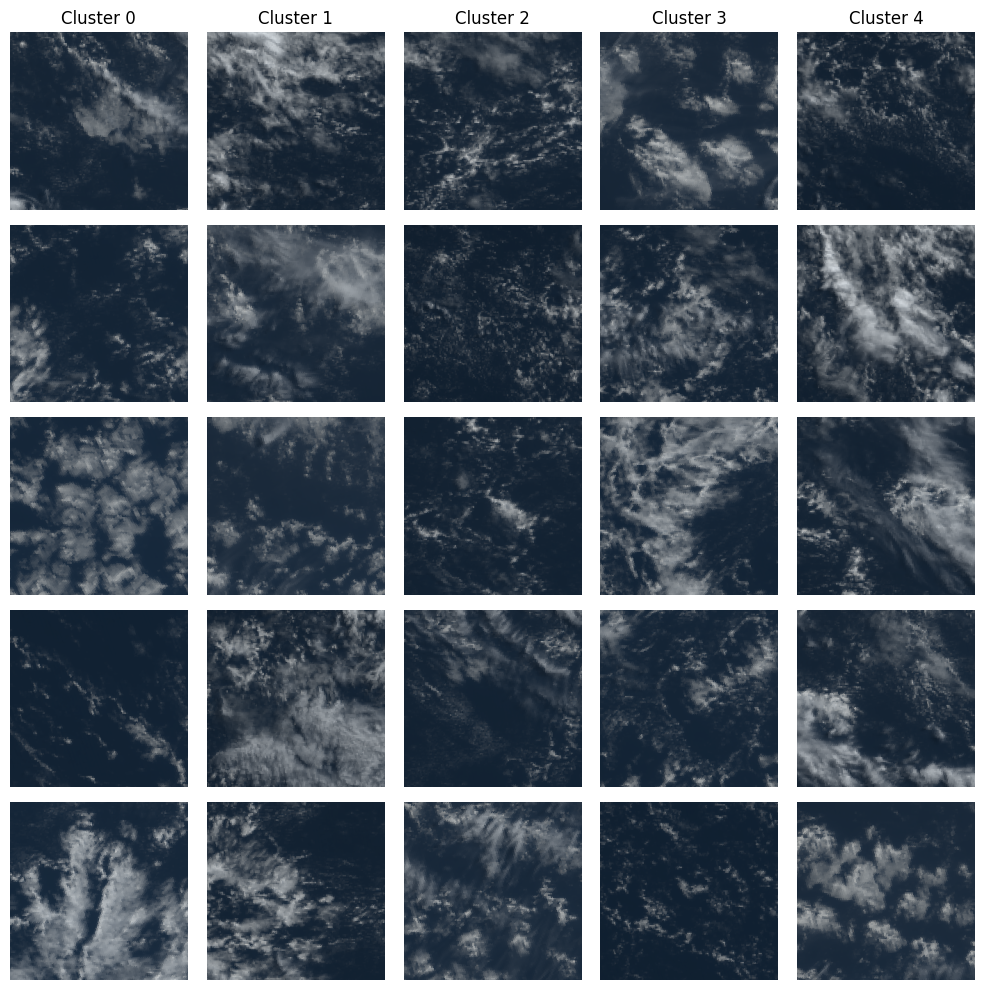

In [15]:
_ = plot_cluster_tiles(cluster_labels, test_ds_no_transform, num_samples=5)

In [16]:
from sklearn.metrics import silhouette_samples


# Silhouette for each sample
sil_samples = silhouette_samples(embeddings, cluster_labels)

# Per-cluster silhouette
unique_clusters = np.unique(cluster_labels)
cluster_silhouettes = {}

for c in unique_clusters:
    cluster_silhouettes[c] = sil_samples[cluster_labels == c].mean()
    print(f"Cluster {c}: silhouette = {cluster_silhouettes[c]:.4f}")

# Average silhouette
overall_silhouette = sil_samples.mean()
print(f"Mean silhouette score: {overall_silhouette:.4f}")

Cluster 0: silhouette = 0.1871
Cluster 1: silhouette = 0.0060
Cluster 2: silhouette = 0.1949
Cluster 3: silhouette = 0.0138
Cluster 4: silhouette = 0.0438
Mean silhouette score: 0.0782
